# Exploring parquet datasets

Parquet files are a columinar data format we can use to store dataframes. They can be stored in partitions, which can allow us to load only a subset of the data. This is useful is we are filtering the data, as we can do that without loading it all into memory.

Import stuff:

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

## Load data
Here we use the UCI heart disease data set found on Kaggle:  
`https://www.kaggle.com/ronitf/heart-disease-uci`

In [2]:
dir_path = os.getcwd()
heart_data = pd.read_csv(os.path.join(dir_path, "data", "heart.csv"))
heart_data.sort_values(by=["age", "sex", "cp"], inplace=True)
heart_data.reset_index(inplace=True, drop=True)
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
1,34,0,1,118,210,0,1,192,0,0.7,2,0,2,1
2,34,1,3,118,182,0,0,174,0,0.0,2,0,2,1
3,35,0,0,138,183,0,1,182,0,1.4,2,0,2,1
4,35,1,0,120,198,0,1,130,1,1.6,1,0,3,0


## Partition data
To split the data we need an appropriate column to split by. Based on it's histogram, we can use the age column to divide the data.

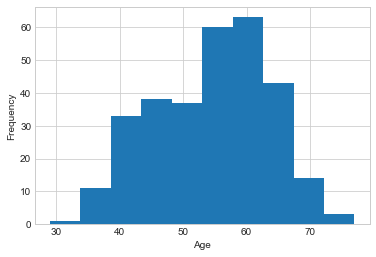

In [3]:
heart_data["age"].plot(kind="hist")
plt.xlabel("Age")
plt.show()

heart_data["partition"] = (heart_data["age"] / 10).round().astype(int)

## Save data
We save the data to parquet files twice: once normally and once with partitioning.

When saving the file normally we produce a single `heart.parquet` file. When saving with partitions we create a folder `heart_partition` as follows:
```
heart_partition
├── bracket=3
│   └── ___.parquet
├── bracket=4
│   └── ___.parquet
...
└── bracket=8
    └── ___.parquet
```

Each column we use for partitioning the dataframe splits the folder structure, and the filtered data will be saved as a parquet file inside the respective folder.

In [4]:
# Save to parquet
heart_data.to_parquet(
    os.path.join(dir_path, "data", "heart.parquet"), index=False,
)

# Save to partitioned parquet
heart_data.to_parquet(
    os.path.join(dir_path, "data", "heart_partition"),
    partition_cols=["partition"],
    index=False,
)

## Loading and testing
Pandas also supports loading from partitioned parquet datasets. Instead of loading the `.parquet` files we can point to the directory to load the whole dataset.

We resort the data after loading the partitioned dataset. When we load we concatenate the various partitions together so the ordering may not be preserved.
The `partition` column is loaded as a categorical type, so we convert back to `int` to ensure its the same as before.

In [5]:
# Load single parquet file
heart_data_1 = pd.read_parquet(os.path.join(dir_path, "data", "heart.parquet"))

# Load parquet dataset
heart_data_2 = pd.read_parquet(
    os.path.join(dir_path, "data", "heart_partition")
)
heart_data_2.sort_values(by=["age", "sex", "cp"], inplace=True)
heart_data_2["partition"] = heart_data_2["partition"].astype(int)

Comparing the resulting dataframes to the original show that they are all identical:

In [6]:
pd.testing.assert_frame_equal(heart_data, heart_data_1)
pd.testing.assert_frame_equal(heart_data, heart_data_2)

## Loading a subset of data
Usually if we wanted a subset of the data, we would load the whole dataframe and filter it in memory.
One of the benefits of using partitioned datasets is that we can load a subset of data directly from disk without needing to load all the data first.
This is possible when we are filtering on one of the partition columns. This can help reduce the memory footprint of a program.

For example, in the following example we filter for the 3rd parition. 

In [7]:
# Load and then filter single parquet file
heart_data_1 = pd.read_parquet(os.path.join(dir_path, "data", "heart.parquet"))
filt = heart_data_1["partition"]==3
heart_data_1 = heart_data_1.loc[filt,:]

# Filter and load parquet dataset
heart_data_2 = pd.read_parquet(
    os.path.join(dir_path, "data", "heart_partition"), filters=[("partition", '=', '3')]
)
heart_data_2.sort_values(by=["age", "sex", "cp"], inplace=True)
heart_data_2["partition"] = heart_data_2["partition"].astype(int)

# Results are identical
pd.testing.assert_frame_equal(heart_data_1, heart_data_2)